**Import Libraries:**

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


**Load and Inspect Data:**


In [9]:
# Load the dataset
df = pd.read_csv('earthquakes_2023_global.csv')

# Inspect the first few rows of the dataset
print(df.head(4))


                       time  latitude  longitude   depth   mag magType   nst  \
0  2023-01-01T00:49:25.294Z   52.0999   178.5218  82.770  3.10      ml  14.0   
1  2023-01-01T01:41:43.755Z    7.1397   126.7380  79.194  4.50      mb  32.0   
2  2023-01-01T03:29:31.070Z   19.1631   -66.5251  24.000  3.93      md  23.0   
3  2023-01-01T04:09:32.814Z   -4.7803   102.7675  63.787  4.30      mb  17.0   

   gap    dmin   rms  ...                   updated  \
0  139  0.8700  0.18  ...  2023-03-11T22:51:52.040Z   
1  104  1.1520  0.47  ...  2023-03-11T22:51:45.040Z   
2  246  0.8479  0.22  ...  2023-03-11T22:51:29.040Z   
3  187  0.4570  0.51  ...  2023-03-11T22:51:45.040Z   

                                   place        type horizontalError  \
0  Rat Islands, Aleutian Islands, Alaska  earthquake            8.46   
1        23 km ESE of Manay, Philippines  earthquake            5.51   
2                     Puerto Rico region  earthquake            0.91   
3     99 km SSW of Pagar Alam, Indo

**Data Preprocessing:**

In [10]:

# Convert time column to datetime, coercing errors
df['time'] = pd.to_datetime(df['time'], errors='coerce')

# Drop rows with NaT values in the time column
df = df.dropna(subset=['time'])

# Convert time to ordinal date for modeling
df['date_ordinal'] = df['time'].map(pd.Timestamp.toordinal)

# Set the time column as the index
df.set_index('time', inplace=True)

# Ensure the 'mag' column contains only numeric values, coercing errors
df['mag'] = pd.to_numeric(df['mag'], errors='coerce')

# Drop rows with NaN values in the 'mag' column
df = df.dropna(subset=['mag'])

# Check for missing values
print(df.isnull().sum())

# Fill or drop missing values as needed
df = df.fillna(method='ffill')


latitude              0
longitude             0
depth                 0
mag                   0
magType               0
nst                1415
gap                1417
dmin               1866
rms                   0
net                   0
id                    0
updated               0
place              1608
type                  0
horizontalError    1549
depthError            0
magError           1672
magNst             1577
status                0
locationSource        0
magSource             0
date_ordinal          0
dtype: int64


**Feature Engineering and Aggregation:**

In [11]:
# Feature Engineering
df['day_of_week'] = df.index.dayofweek
df['month'] = df.index.month

# Aggregate data by day (e.g., taking the mean magnitude per day)
df_daily = df['mag'].resample('D').mean()



**Seasonal Decomposition:**

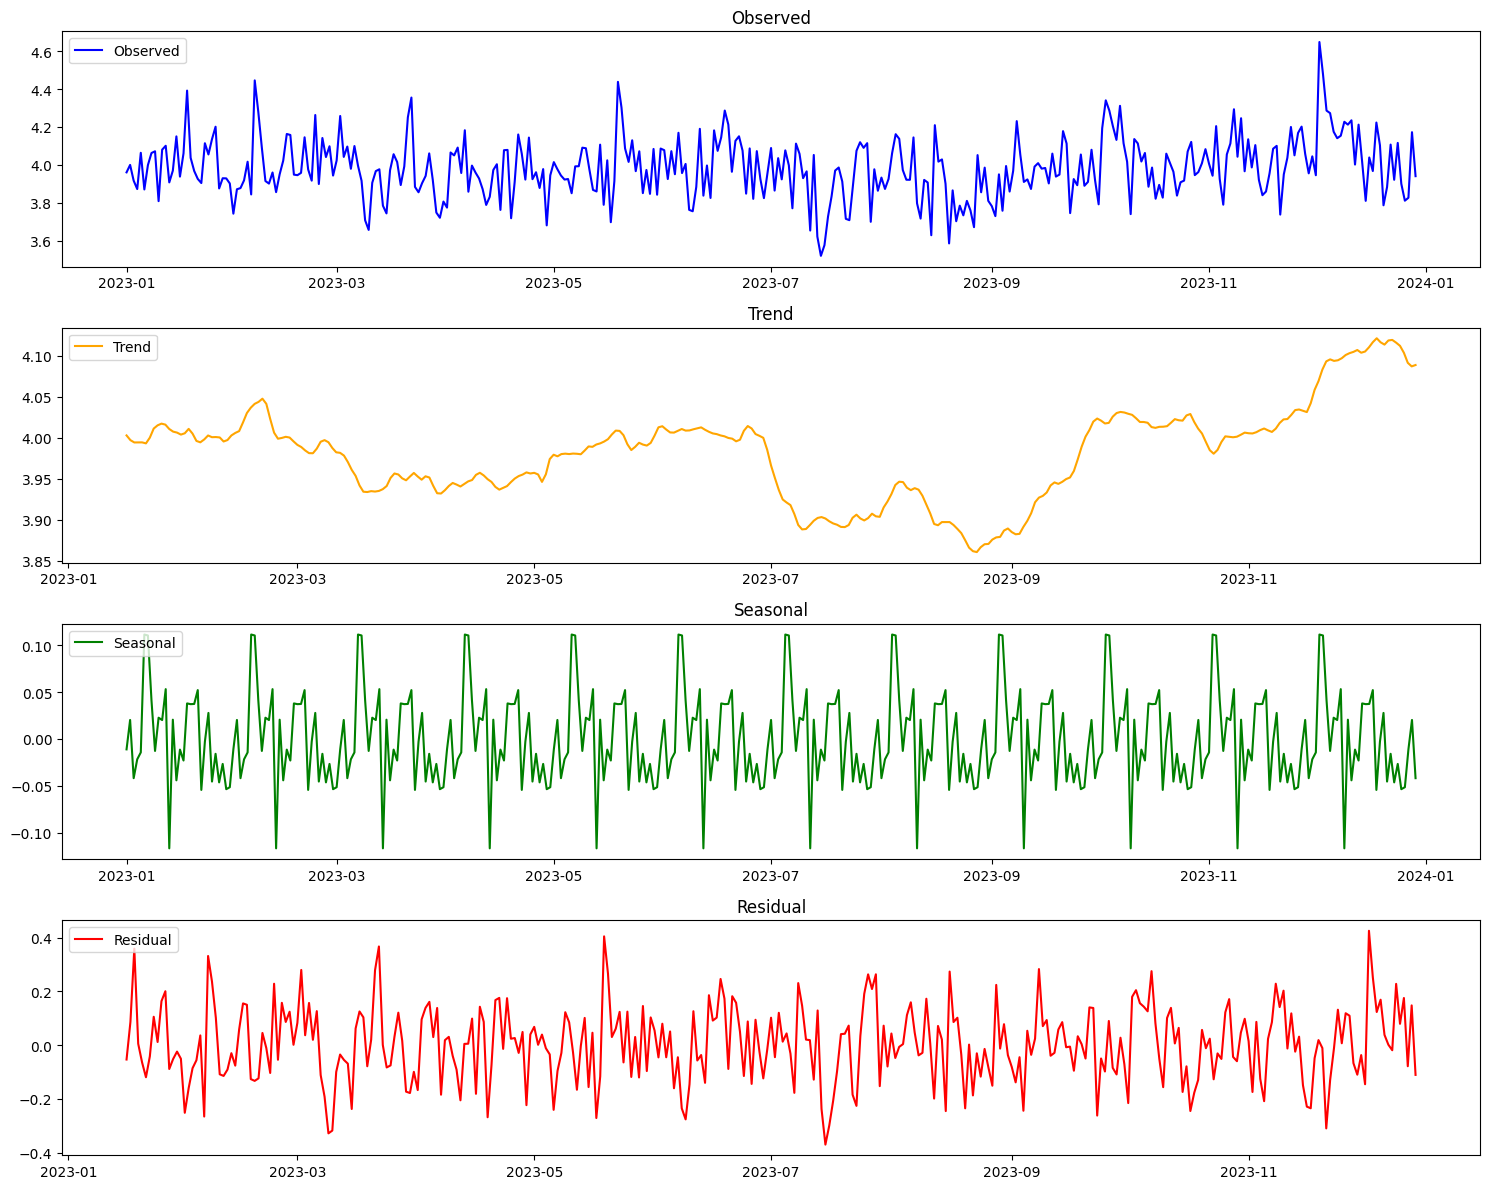

In [12]:
# Perform seasonal decomposition on the daily aggregated data
decomposition = seasonal_decompose(df_daily, model='additive', period=30)  # Adjust period as needed

# Plot the decomposed components
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(15, 12))

ax1.plot(decomposition.observed, label='Observed', color='blue')
ax1.legend(loc='upper left')
ax1.set_title('Observed')

ax2.plot(decomposition.trend, label='Trend', color='orange')
ax2.legend(loc='upper left')
ax2.set_title('Trend')

ax3.plot(decomposition.seasonal, label='Seasonal', color='green')
ax3.legend(loc='upper left')
ax3.set_title('Seasonal')

ax4.plot(decomposition.resid, label='Residual', color='red')
ax4.legend(loc='upper left')
ax4.set_title('Residual')

plt.tight_layout()
plt.show()


**Autocorrelation Plots**

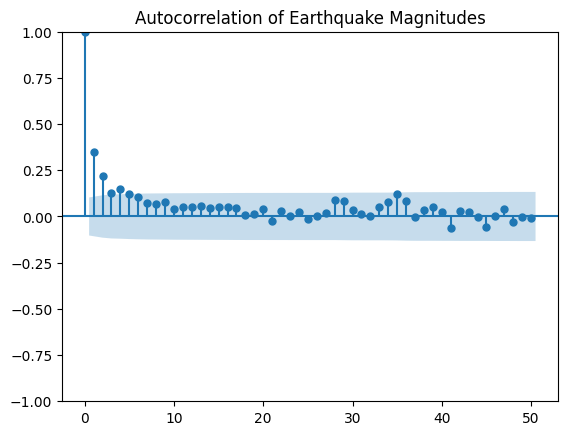

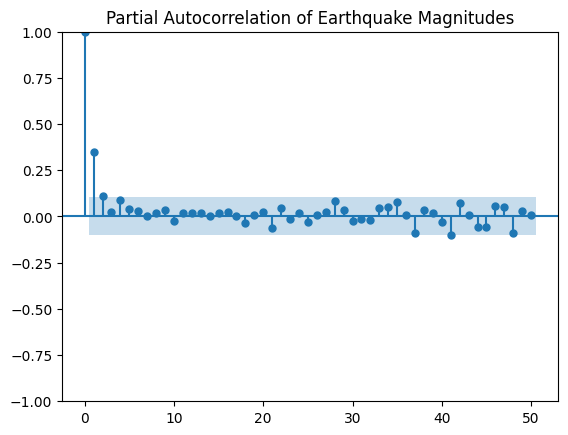

In [13]:
# Plot autocorrelation and partial autocorrelation
plot_acf(df_daily.dropna(), lags=50, title='Autocorrelation of Earthquake Magnitudes')
plt.show()

plot_pacf(df_daily.dropna(), lags=50, title='Partial Autocorrelation of Earthquake Magnitudes')
plt.show()


**Linear Regression Model:**

In [15]:
# Prepare the features and target variable
X = df[['date_ordinal', 'latitude', 'longitude', 'horizontalError', 'depthError', 'day_of_week', 'month']]
y = df['mag']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# Fit the linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict the values
y_pred = model.predict(X_test)


**Model Evaluation:**

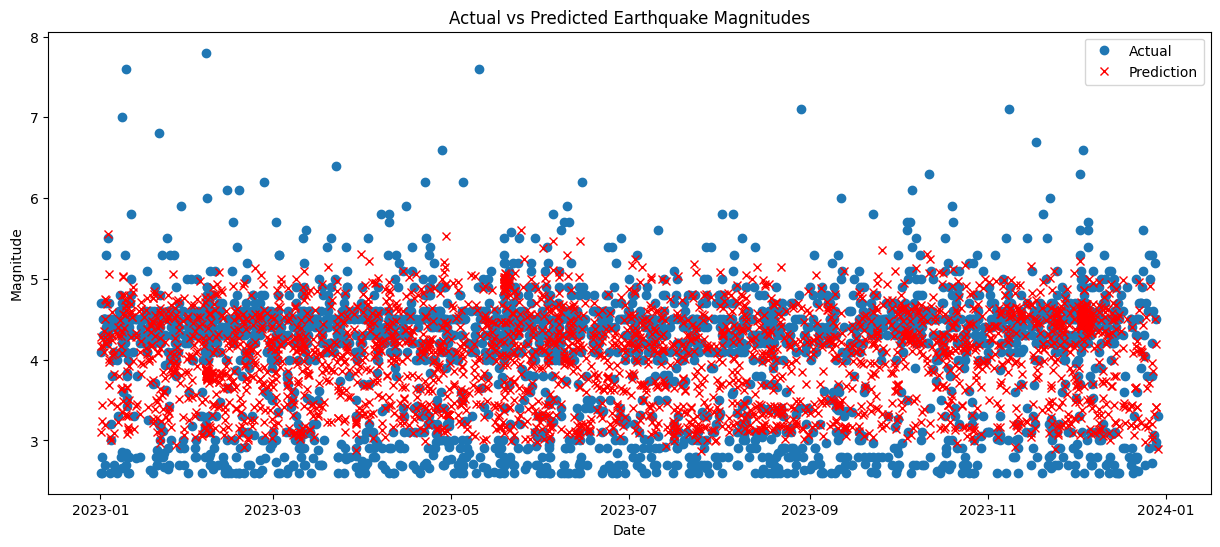

Mean Absolute Error: 0.4426384337654317
Mean Squared Error: 0.33091569056472375


In [16]:
# Plot the results
plt.figure(figsize=(15, 6))
plt.plot(X_test.index, y_test, label='Actual', marker='o', linestyle='None')
plt.plot(X_test.index, y_pred, label='Prediction', color='red', linestyle='None', marker='x')
plt.xlabel('Date')
plt.ylabel('Magnitude')
plt.title('Actual vs Predicted Earthquake Magnitudes')
plt.legend()
plt.show()

# Evaluation Metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Absolute Error: {mae}')
print(f'Mean Squared Error: {mse}')


**Additional Exploratory Data Analysis:**

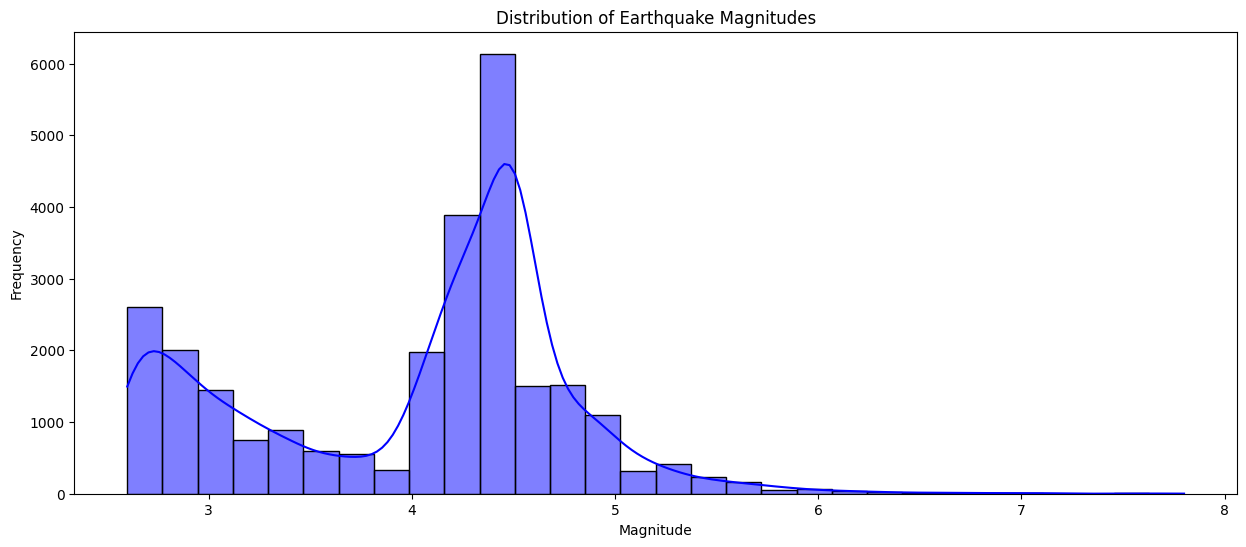

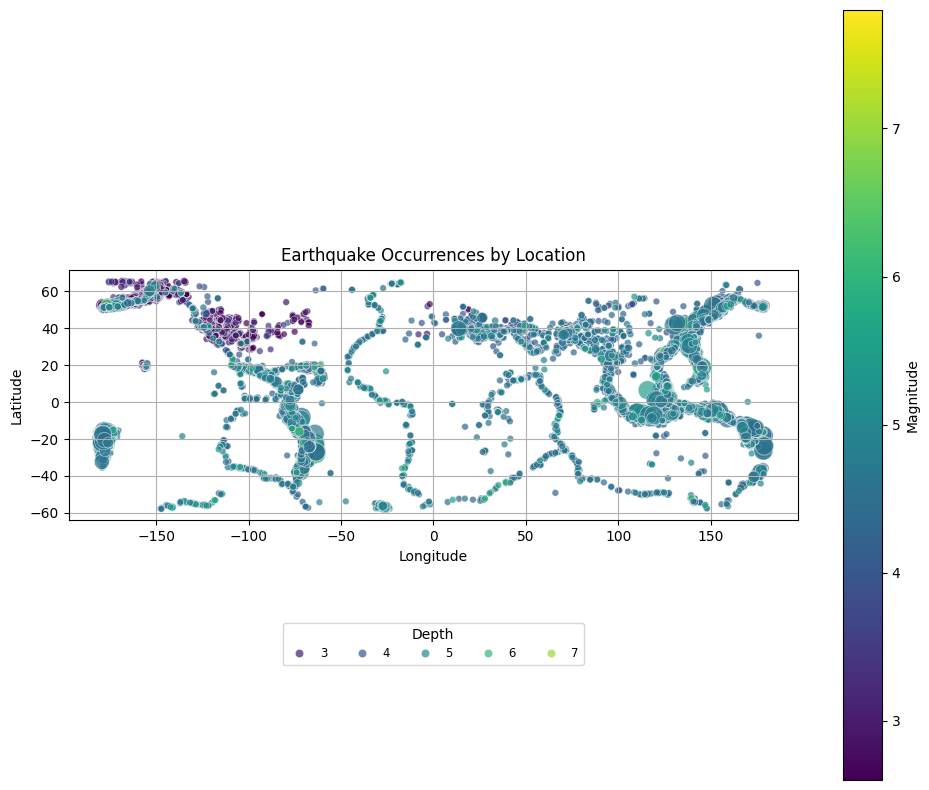

In [31]:
# Additional EDA: Visualizing Earthquake Occurrences
plt.figure(figsize=(15, 6))
sns.histplot(df['mag'], bins=30, kde=True, color='blue')
plt.title('Distribution of Earthquake Magnitudes')
plt.xlabel('Magnitude')
plt.ylabel('Frequency')
plt.show()


# Assuming 'df' is already defined and contains the relevant data
# Remove outliers for better visualization
df_clean = df[(df['latitude'].between(df['latitude'].quantile(0.01), df['latitude'].quantile(0.99))) &
              (df['longitude'].between(df['longitude'].quantile(0.01), df['longitude'].quantile(0.99)))]

plt.figure(figsize=(10, 8))  # Adjusted figure size

# Adjust transparency of points and use Seaborn to create the scatter plot
scatter = sns.scatterplot(x='longitude', y='latitude', hue='mag', size='depth', data=df_clean, palette='viridis', sizes=(20, 200), alpha=0.7)

# Create a color bar that accurately maps the hue (magnitude) values
norm = plt.Normalize(df_clean['mag'].min(), df_clean['mag'].max())
sm = plt.cm.ScalarMappable(cmap="viridis", norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=scatter.axes, label='Magnitude')

# Create a separate legend for the size variable (depth)
handles, labels = scatter.get_legend_handles_labels()
depth_handles = handles[1:len(handles)//2]  # Handles for size legend (depth)
depth_labels = labels[1:len(labels)//2]  # Labels for size legend (depth)

# Move the depth legend outside below the plot horizontally
plt.legend(handles=depth_handles, labels=depth_labels, title='Depth', loc='lower center', bbox_to_anchor=(0.5, -0.6), ncol=5, fontsize='small')

plt.title('Earthquake Occurrences by Location')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.gca().set_aspect('equal', adjustable='box')  # Adjust aspect ratio
plt.grid(True)  # Add grid lines
plt.tight_layout()  # Adjust layout
plt.show()
